<a href="https://colab.research.google.com/github/adarshkumar00/Asknbid_project/blob/master/AsknBid_stocks_price_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [128]:
df1 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/asknbid dataset/fundamentals.csv")
df2 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/asknbid dataset/prices-split-adjusted.csv")
df3 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/asknbid dataset/prices.csv")
df4 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/asknbid dataset/securities.csv")
print(list(map(len ,[df1,df2,df3,df4])))

[1781, 851264, 851264, 505]


In [129]:
df1.head()

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,Cost of Revenue,Current Ratio,Deferred Asset Charges,Deferred Liability Charges,Depreciation,Earnings Before Interest and Tax,Earnings Before Tax,Effect of Exchange Rate,Equity Earnings/Loss Unconsolidated Subsidiary,Fixed Assets,Goodwill,Gross Margin,Gross Profit,Income Tax,Intangible Assets,Interest Expense,Inventory,Investments,Liabilities,Long-Term Debt,Long-Term Investments,Minority Interest,Misc. Stocks,Net Borrowings,Net Cash Flow,Net Cash Flow-Operating,Net Cash Flows-Financing,Net Cash Flows-Investing,Net Income,Net Income Adjustments,Net Income Applicable to Common Shareholders,Net Income-Cont. Operations,Net Receivables,Non-Recurring Items,Operating Income,Operating Margin,Other Assets,Other Current Assets,Other Current Liabilities,Other Equity,Other Financing Activities,Other Investing Activities,Other Liabilities,Other Operating Activities,Other Operating Items,Pre-Tax Margin,Pre-Tax ROE,Profit Margin,Quick Ratio,Research and Development,Retained Earnings,Sale and Purchase of Stock,"Sales, General and Admin.",Short-Term Debt / Current Portion of Long-Term Debt,Short-Term Investments,Total Assets,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,127000000.0,1.049900e+10,78.0,0.000000e+00,223000000.0,1.001000e+09,-1.813000e+09,-2.445000e+09,0.0,0.0,1.340200e+10,0.000000e+00,58.0,1.435600e+10,-5.690000e+08,8.690000e+08,632000000.0,5.800000e+08,3.060000e+08,4.730000e+08,7.116000e+09,0.0,0.0,0.0,-1.020000e+09,197000000.0,1.285000e+09,4.830000e+08,-1.571000e+09,-1.876000e+09,2.050000e+09,-1.876000e+09,-4.084000e+09,1.124000e+09,3.860000e+08,1.480000e+08,1.0,2.167000e+09,6.260000e+08,4.524000e+09,-2.980000e+09,1.509000e+09,11000000.0,1.514700e+10,-141000000.0,8.450000e+08,10.0,31.0,8.0,72.0,0.0,-9.462000e+09,0.000000e+00,1.297700e+10,1.419000e+09,3.412000e+09,2.351000e+10,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,5000000.0,1.101900e+10,104.0,0.000000e+00,935000000.0,1.020000e+09,-1.324000e+09,-2.180000e+09,0.0,0.0,1.925900e+10,4.086000e+09,59.0,1.572400e+10,-3.460000e+08,2.311000e+09,856000000.0,1.012000e+09,-1.181000e+09,-2.350000e+08,1.535300e+10,0.0,0.0,0.0,2.208000e+09,660000000.0,6.750000e+08,3.799000e+09,-3.814000e+09,-1.834000e+09,1.873000e+09,-1.834000e+09,-4.489000e+09,1.560000e+09,5.590000e+08,1.399000e+09,5.0,2.299000e+09,1.465000e+09,7.385000e+09,-2.032000e+09,1.711000e+09,481000000.0,1.491500e+10,-56000000.0,8.530000e+08,8.0,80.0,7.0,96.0,0.0,-1.129600e+10,0.000000e+00,1.291300e+10,1.446000e+09,8.111000e+09,4.227800e+10,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.0,7000000.0,1.562000e+10,88.0,0.000000e+00,829000000.0,1.342000e+09,4.099000e+09,3.212000e+09,0.0,0.0,2.308400e+10,4.091000e+09,63.0,2.703000e+10,3.300000e+08,2.240000e+09,887000000.0,1.004000e+09,1.799000e+09,-1.026000e+09,1.604300e+10,0.0,0.0,0.0,1.700000e+08,-146000000.0,3.080000e+09,-3.150000e+08,-2.911000e+09,2.882000e+09,5.420000e+08,2.882000e+09,2.882000e+09,1.771000e+09,8.000000e+08,4.249000e+09,10.0,2.060000e+09,8.980000e+08,7.059000e+09,-4.559000e+09,8.170000e+08,601000000.0,1.092800e+10,-500000000.0,1.295000e+09,8.0,159.0,7.0,80.0,0.0,-8.562000e+09,-1.052000e+09,2.068600e+10,1.677000e+09,6.309000e+09,4.322

In [130]:
len(np.unique(np.array(df1)[:,1]))

448

In [131]:
df3.head()


,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [132]:
df4.head()

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152
3,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373
4,ATVI,Activision Blizzard,reports,Information Technology,Home Entertainment Software,"Santa Monica, California",2015-08-31,718877


In [133]:
#np.unique(sorted(np.array(df4)[:,0]))#print all the companies symbols

In [134]:

array = np.array(df2)
print(len(np.unique(array[:,1])))#print the count of all the companies
# for symbol in np.unique(array[:,1]):
#     print(len(array[array[:,1]==symbol]))

501


In [135]:
company_stocks_details = {}
#for each company symbol as key store all its stocks price data as values
for symbol in np.unique(array[:,1]):
    company_stocks_details[symbol]= array[array[:,1] == symbol]

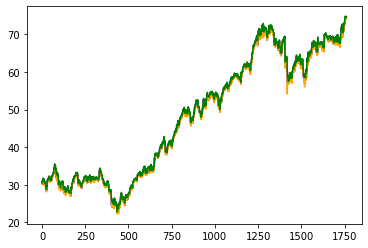

In [136]:
company_stocks_data =company_stocks_details['ALL'][:,2:6]
#plot the high , low , opening , closing prices of a company 
plt.plot(np.arange(len(company_stocks_data)),company_stocks_data[:,0]  ,color = 'red')
plt.plot(np.arange(len(company_stocks_data)) , company_stocks_data[:,1] ,color = 'blue')
plt.plot(np.arange(len(company_stocks_data)) , company_stocks_data[:,2] ,color = 'orange')
plt.plot(np.arange(len(company_stocks_data)), company_stocks_data[:,3] ,color = 'green')
plt.show()

In [137]:
#check if dates got shuffled if dates are not continuous or in ascending order it will get fail
#and terminate
for key in company_stocks_details.keys():
    date = company_stocks_details[key][0,0];
    prev_date=list(map(int,date.split('-')))
    for date in company_stocks_details[key][1:,0]:
        date = list(map(int,date.split('-')))
        if ((prev_date[2]<date[2]) and (prev_date[1]==date[1]) and (prev_date[0]==prev_date[0])) or((prev_date[2]>date[2]) and (prev_date[1]<date[1]) and (prev_date[0]==prev_date[0])) or((prev_date[2]>date[2]) and (prev_date[1]>date[1]) and (prev_date[0]<date[0])):
            prev_date = date
        else :
            prev_date=date
            print(date , prev_date)
            print(key  , 'fail')
            break

In [138]:
#standardization and normalization and making sequences
def data_preprocessing(stocks_details,key, seq_len):
    data = np.array(stocks_details[key][:,2:6])
    data = np.array(data ,dtype  = np.int32)
    data = (data - np.mean(data , axis =0))/np.std(data , axis=0)
    data = (data - np.min(data , axis = 0))/(np.max(data , axis =0)-np.min(data , axis = 0))
    x = []
    y = []
    for i in range(len(data)-seq_len):
        x.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    stocks_details[key] =[x,y]
    return stocks_details
seq_len=20
stocks_details = company_stocks_details.copy()
for key in stocks_details.keys():
    stocks_details = data_preprocessing(stocks_details ,key, seq_len =20)

In [139]:
import tensorflow as tf
from tensorflow.keras.models import Model

In [140]:
#since there are 501 companies so initialize an embedding layer to map the different type of
#companies into a different vector .

class CustomModel(Model):
    def __init__(self,**kwargs):
        super(CustomModel , self).__init__(**kwargs)
        self.embedding = tf.keras.layers.Embedding(input_dim  = 502 , output_dim=32)
        self.gru1 = tf.keras.layers.GRU(units = 32 , return_state = True)
        self.dense= tf.keras.layers.Dense(units = 4 , activation ='sigmoid')
    def call(self,company_names , inputs ):
        embed_vector = self.embedding(company_names)
        embed_vector = tf.squeeze(embed_vector , axis = 1)
        #print(inputs.shape , embed_vector.shape)
        gru_output,cell_state = self.gru1(inputs , initial_state=[embed_vector])
        output = self.dense(gru_output)
        return output

In [141]:
data = tf.random.uniform(shape =[16,19,1] , dtype = tf.float32) #initialize a dummy data
company_names = tf.random.uniform(shape  = [16,1] ,maxval = 501 )
model = CustomModel()
output = model(company_names , data)#test the model
print(output.shape)#print the output shape

(16, 4)


In [142]:
#initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
#initialize a loss object
loss_obj = tf.keras.losses.MeanSquaredError()


In [143]:
#give each company name a numerical value 
company_names ={}
company_names = {key:i+1 for i,key in enumerate(prices.keys())}
print(company_names)

{'A': 1, 'AAL': 2, 'AAP': 3, 'AAPL': 4, 'ABBV': 5, 'ABC': 6, 'ABT': 7, 'ACN': 8, 'ADBE': 9, 'ADI': 10, 'ADM': 11, 'ADP': 12, 'ADS': 13, 'ADSK': 14, 'AEE': 15, 'AEP': 16, 'AES': 17, 'AET': 18, 'AFL': 19, 'AGN': 20, 'AIG': 21, 'AIV': 22, 'AIZ': 23, 'AJG': 24, 'AKAM': 25, 'ALB': 26, 'ALK': 27, 'ALL': 28, 'ALLE': 29, 'ALXN': 30, 'AMAT': 31, 'AME': 32, 'AMG': 33, 'AMGN': 34, 'AMP': 35, 'AMT': 36, 'AMZN': 37, 'AN': 38, 'ANTM': 39, 'AON': 40, 'APA': 41, 'APC': 42, 'APD': 43, 'APH': 44, 'ARNC': 45, 'ATVI': 46, 'AVB': 47, 'AVGO': 48, 'AVY': 49, 'AWK': 50, 'AXP': 51, 'AYI': 52, 'AZO': 53, 'BA': 54, 'BAC': 55, 'BAX': 56, 'BBBY': 57, 'BBT': 58, 'BBY': 59, 'BCR': 60, 'BDX': 61, 'BEN': 62, 'BHI': 63, 'BIIB': 64, 'BK': 65, 'BLK': 66, 'BLL': 67, 'BMY': 68, 'BSX': 69, 'BWA': 70, 'BXP': 71, 'C': 72, 'CA': 73, 'CAG': 74, 'CAH': 75, 'CAT': 76, 'CB': 77, 'CBG': 78, 'CBS': 79, 'CCI': 80, 'CCL': 81, 'CELG': 82, 'CERN': 83, 'CF': 84, 'CFG': 85, 'CHD': 86, 'CHK': 87, 'CHRW': 88, 'CHTR': 89, 'CI': 90, 'CINF': 9

In [144]:
model=CustomModel()#initialize model

In [145]:
def grad(model , company_name , x,y ,loss_obj,batch_size=32):
    with tf.GradientTape() as tape:
        #since all the examples in a batch is of a single company so tile a company name to 
        #the size of batch
        company_name=np.tile([company_name],[batch_size,1])
        output = model( company_name, x)
        loss = loss_obj(y_true = y , y_pred = output)
        grads = tape.gradient(loss , model.trainable_variables)
    return grads,loss,output

In [146]:
#print the predicted graph of the company 
def show_company_graph(company_name , company_stocks_data):
    company_stocks_data = np.array(company_stocks_data).reshape([-1,4])
    plt.plot(np.arange(len(company_stocks_data)),company_stocks_data[:,0]  ,color = 'red')
    plt.plot(np.arange(len(company_stocks_data)) , company_stocks_data[:,1] ,color = 'blue')
    plt.plot(np.arange(len(company_stocks_data)) , company_stocks_data[:,2] ,color = 'orange')
    plt.plot(np.arange(len(company_stocks_data)), company_stocks_data[:,3] ,color = 'green')
    plt.show()

In [147]:
def unroll_val_x(val_x):
    length_of_a_sequence = len(val_x[0])
    validation_x = []
    validation_y = []
    for sequence in val_x:
        for i in range(length_of_a_sequence-1):
            validation_x.append(sequence[i])
            validation_y.append(sequence[i+1])
    validation_x = np.array(validation_x)
    validation_y= np.array(validation_y)
    #print(validation_x.shape , validation_y.shape)
    return validation_x,validation_y
def make_validation_dataset(company_name , companies_data , batch_size):
    x= companies_data[company_name][0]
    if (len(x)%batch_size==0):#if the dataset of company has no remaining batches at end
        x = np.array(x)
        val_x = x[-batch_size:]#then pick up the last batch
    else :
        val_x = x[-(len(x)%batch_size):]#or pick up the data which we'll no train or data remaining
        #out of batches
    val_x , val_y = unroll_val_x(val_x)#since every example is a sequence of some timestamps so unroll
    #each timestamp as make each timestamp a single validation example
    val_x = np.expand_dims(val_x , axis=1)#since gru layer nedd 3d input and here we need to consider
    #each example a batch in itself
    #print(val_x.shape)
    return val_x , val_y

epoch: 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Company name :  A
Validation loss :  0.0005319541


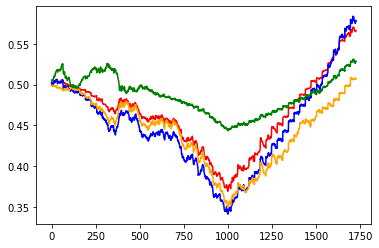

Company name :  AAL
Validation loss :  0.0003463347


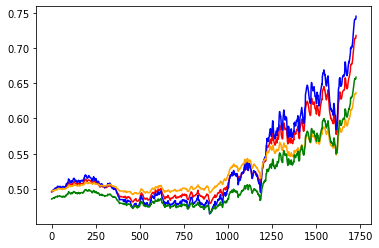

Company name :  AAP
Validation loss :  0.0003681288


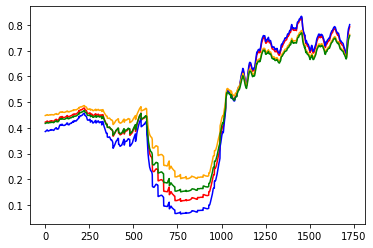

Company name :  AAPL
Validation loss :  0.00034215208


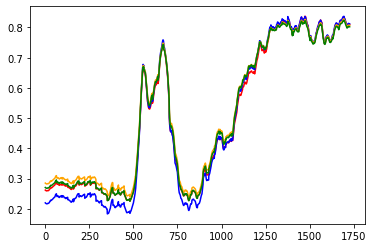

Company name :  ABBV
Validation loss :  0.00011834481


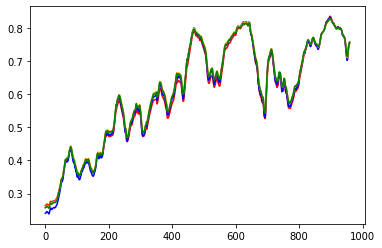

Company name :  ABC
Validation loss :  2.4775904e-05


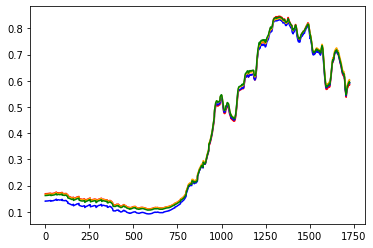

Company name :  ABT
Validation loss :  1.951611e-05


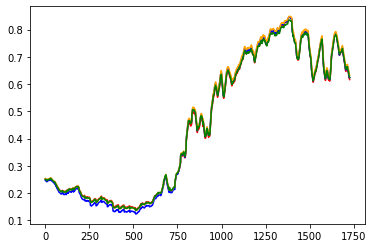

Company name :  ACN
Validation loss :  0.00067746977


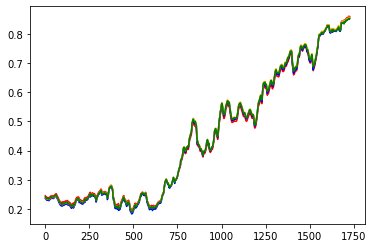

Company name :  ADBE
Validation loss :  0.00074806437


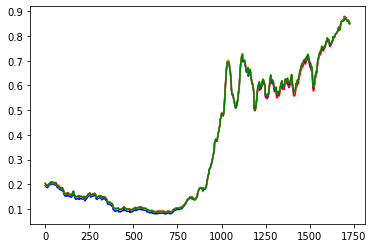

Company name :  ADI
Validation loss :  0.00079188345


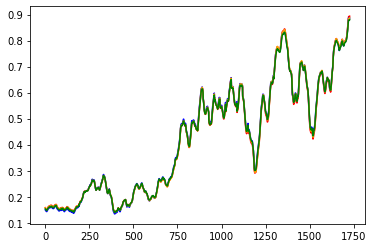

Company name :  ADM
Validation loss :  0.00017185659


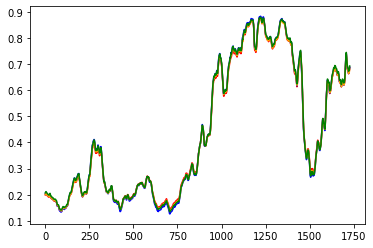

Company name :  ADP
Validation loss :  0.00049828755


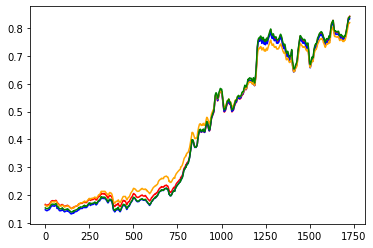

Company name :  ADS
Validation loss :  0.00013236828


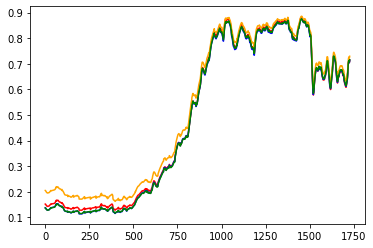

Company name :  ADSK
Validation loss :  0.00037033838


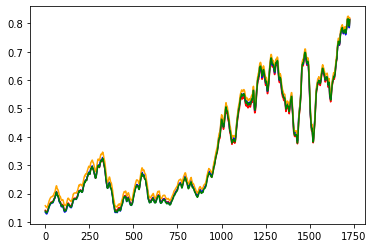

Company name :  AEE
Validation loss :  0.0004326196


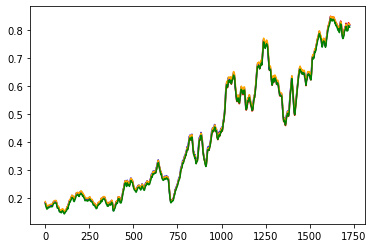

Company name :  AEP
Validation loss :  0.00025498957


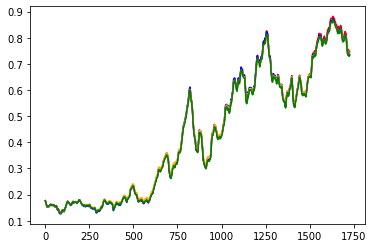

Company name :  AES
Validation loss :  8.9194755e-06


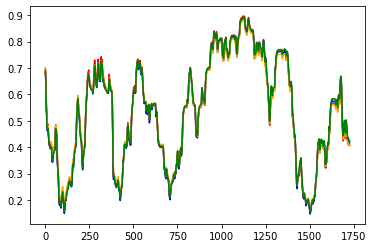

Company name :  AET
Validation loss :  0.0003577835


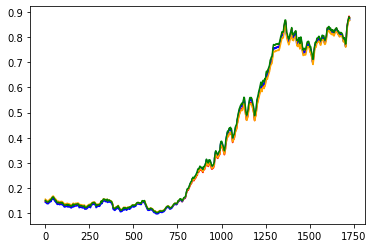

Company name :  AFL
Validation loss :  0.0005445661


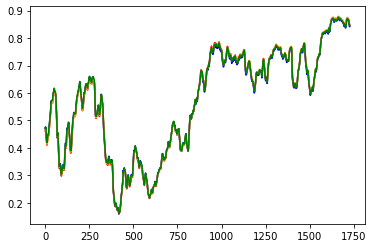

Company name :  AGN
Validation loss :  1.134299e-06


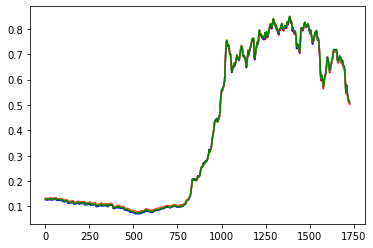

Company name :  AIG
Validation loss :  0.00060763257


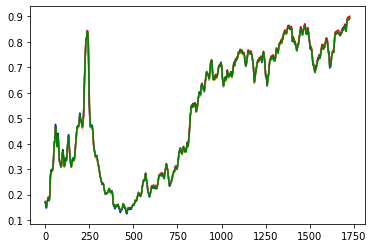

Epoch  0  loss :  0.0005467303


In [148]:
batch_size = 32
epochs=1
for epoch in range (epochs):
    epoch_loss=0#initialize the number of epochs
    print("epoch:" , epoch )
    for company_num,key in enumerate(stocks_details.keys()):#this loop will run for each company
        num_batches = len(stocks_details[key][0])//batch_size#divide one company dataset into batches
        val_x , val_y = make_validation_dataset(key , stocks_details,batch_size)
        company_loss=0#training loss
        company_output=[]#store each company output to print out a  output graph
        company_val_loss = 0#validataion loss
        for j in range(num_batches):
            x = np.array(stocks_details[key][0][j*batch_size : (j+1)*batch_size])
            y = np.array(stocks_details[key][1][j*batch_size : (j+1)*batch_size])
            grads,loss,output= grad(model,company_names[key],x,y,loss_obj)
            optimizer.apply_gradients(zip(grads , model.trainable_variables))
            #since each validation example is a batch in itself and have a single timestamp per
            #sequence so the batch size is equal to length of whole validation set
            _,validation_loss,_= grad(model,company_names[key],val_x,val_y,loss_obj,batch_size=len(val_x))
            company_loss+=loss
            company_output.append(output)
        company_loss = company_loss/num_batches
        company_val_loss +=validation_loss/len(val_x)
        epoch_loss+=company_loss
        print("Company name : " , key)
        print("Validation loss : " ,company_val_loss.numpy())
        show_company_graph(key,company_output)
        if(company_num == 20):#just print the output graph of 20 company otherwise there are 501 companies
            #it will take hours just to complete 1 epoch;
            break
    epoch_loss = epoch_loss/len(stocks_details.keys())
    print("Epoch " , epoch ," loss : " , epoch_loss.numpy())#print the 1 epoch training loss at completion of 1 epoch
    


In [149]:
import matplotlib.pyplot as plt

In [150]:
company_output = np.array(company_output).reshape([-1,4])
print(company_output.shape)

(1728, 4)


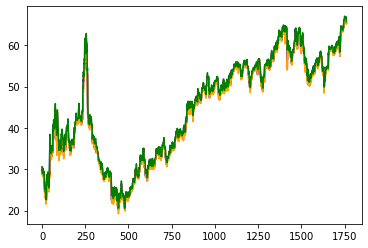

In [151]:
#it is the actual output of a company
company_output =company_stocks_details['AIG'][:,2:6]
plt.plot(np.arange(len(company_output)),company_output[:,0]  ,color = 'red')
plt.plot(np.arange(len(company_output)) , company_output[:,1] ,color = 'blue')
plt.plot(np.arange(len(company_output)) , company_output[:,2] ,color = 'orange')
plt.plot(np.arange(len(company_output)), company_output[:,3] ,color = 'green')
plt.show()